In [1]:
# import xml.etree.ElementTree as ET 

# xml_file = ET.parse('../input/fruit-images-for-object-detection/train_zip/train/apple_1.xml') 

# root = xml_file.getroot()

# for i in range(4):
#     if i == 0: print(f"xmin - {root[6][4][i].text:>3s}")
#     if i == 1: print(f"xmax - {root[6][4][i].text:>3s}")        
#     if i == 2: print(f"ymin - {root[6][4][i].text:>3s}")        
#     if i == 3: print(f"ymax - {root[6][4][i].text:>3s}")        

### **Library Imports**

In [2]:
import os
import re
import cv2
import torch
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms

from sklearn.model_selection import StratifiedKFold

### **Utilities and Constants**

In [3]:
SEED = 42


def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")


def get_images(path: str, filenames: list, size: int=224) -> np.ndarray:
    images = np.zeros((len(filenames), size, size, 3), dtype=np.uint8)
    
    i = 0
    for filename in filenames:
        image = cv2.imread(os.path.join(path, filename), cv2.IMREAD_COLOR)
        if image is not None:
            images[i] = cv2.resize(src=cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB), dsize=(size, size), interpolation=cv2.INTER_AREA)
        else:
            images[i] = images[i-1]
        i += 1
    
    return images


def get_labels_and_boxes(path: str, filenames: list):
    labels: list = []
    bboxes: list = []

    for filename in filenames:
        box: list = []
        root = ET.parse(os.path.join(path, filename)).getroot()
        if re.match(r"^apple$", root[6][0].text, re.IGNORECASE): labels.append(0)
        if re.match(r"^banana$", root[6][0].text, re.IGNORECASE): labels.append(1)
        if re.match(r"^orange$", root[6][0].text, re.IGNORECASE): labels.append(2)
        w, h, c = int(root[4][0].text), int(root[4][1].text), int(root[4][2].text)
        for i in range(4): 
            if w != 0 or h != 0:
                if i == 0 or i == 2: box.append(int(root[6][4][i].text) / w)
                else: box.append(int(root[6][4][i].text) / h)
            else:
                if i == 0 or i == 1: box.append(0)
                else: box.append(1)

        bboxes.append(box)
    
    return np.array(labels), np.array(bboxes)


def show_graphs(L: list, A: list) -> None:
    TL, VL, TA, VA = [], [], [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.subplot(1, 2, 2)
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()
    

# def show_regressor_graphs(L: list) -> None:
#     TL, VL = [], []
#     for i in range(len(L)):
#         TL.append(L[i]["train"])
#         VL.append(L[i]["valid"])
#     x_Axis = np.arange(1, len(TL) + 1)
#     plt.figure(figsize=(8, 6))
#     plt.plot(x_Axis, TL, "r", label="Train")
#     plt.plot(x_Axis, VL, "b", label="Valid")
#     plt.legend()
#     plt.grid()
#     plt.title("Loss Graph")
#     plt.show()

### **Configuration**

In [4]:
class CFG(object):
    def __init__(self, 
                 seed: int = 42,
                 in_channels: int = 3,
                 size: int = 224,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 ):
        
        self.seed = seed
        self.in_channels = in_channels
        self.size = size
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.81346, 0.69145, 0.53863],
                                                     [0.27417, 0.32166, 0.40489]),
                                ])
        self.train_path = "../input/fruit-images-for-object-detection/train_zip/train"
        self.test_path = "../input/fruit-images-for-object-detection/test_zip/test"
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
    
cfg = CFG(seed=SEED, size=224)

### **Dataset Template**

In [5]:
class DS(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, bboxes: np.ndarray, transform=None):
        self.transform = transform
        self.images = images
        self.labels = labels
        self.bboxes = bboxes
    
    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.transform(self.images[idx]), \
               torch.LongTensor(self.labels[idx]), \
               torch.FloatTensor(self.bboxes[idx])

### **Model**

In [6]:
class Model(nn.Module):
    def __init__(self, in_channels: int = 3):
        super(Model, self).__init__()

        self.features = models.resnet50(pretrained=True, progress=True)
        self.freeze()
        self.features = nn.Sequential(*[*self.features.children()][:-1])
        
        self.classifier = nn.Linear(in_features=self.features[-2][-1].bn3.num_features, out_features=3)
        self.regressor = nn.Linear(in_features=self.features[-2][-1].bn3.num_features, out_features=4)
    
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False
    
    def forward(self, x):
        x = nn.Flatten()(self.features(x))
        
        cls_op = nn.LogSoftmax(dim=1)(self.classifier(x))
        reg_op = self.regressor(x)
        
        return cls_op, reg_op

### **Fit and Predict Helper**

In [7]:
def fit(model=None, 
        optimizer=None,
        scheduler_rlrop=None,
        scheduler_oclr=None, 
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None, 
        device=None,
        save_path=None,
        verbose=False) -> tuple:

    def get_accuracy(y_pred, y_true):
        y_pred = torch.argmax(y_pred, dim=1)
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
        
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    bestAccs = {"train" : 0.0, "valid" : 0.0}
    
    Losses, Accuracies, LRs = [], [], []
    
    if fold: name = f"state_fold_{fold}.pt"
    else: name = "state.pt"

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : 0.0, "valid" : 0.0}
        epochAccs = {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
    
            lossPerPass = []
            accsPerPass = []

            for images, labels, bboxes in dataloaders[phase]:
                images, labels, bboxes = images.to(device), labels.to(device).view(-1), bboxes.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    op_CLS, op_REG = model(images)
                    loss = torch.nn.NLLLoss()(op_CLS, labels) + torch.nn.MSELoss()(op_REG, bboxes)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler_oclr: scheduler_oclr.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(op_CLS, labels))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)
        
        if scheduler_oclr:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_oclr.state_dict()}
        
        elif scheduler_rlrop:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_rlrop.state_dict()}
        
        else:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict()}
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save(save_dict, os.path.join(save_path, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save(save_dict, os.path.join(save_path, name))
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1
            # torch.save(save_dict, os.path.join(save_path, name))
        
        if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} |\
 Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, 
                                                                       epochLoss["train"], epochLoss["valid"], 
                                                                       epochAccs["train"], epochAccs["valid"], 
                                                                       time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, Accuracies, LRs, BLE, BAE, name


# def predict_batch(model=None, dataloader=None, device=None, in_channels=None, size=None, path=None) -> np.ndarray:
#     model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
#     model.to(device)    
#     model.eval()
    
#     y_pred = torch.zeros(1, in_channels, size, size).to(device)
    
#     for X in dataloader:
#         X = X.to(device)
#         with torch.no_grad():
#             output = torch.sigmoid(model(X))
#         y_pred = torch.cat((y_pred, output), dim=0)
    
#     return y_pred[1:].detach().cpu().numpy()


# def predict(model=None, device=None, image=None, size=None, path=None) -> np.ndarray:
#     model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
#     model.to(device)    
#     model.eval()
    
#     h, w, _ = image.shape
#     temp_image = cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)

#     with torch.no_grad(): _, decoded = model(transforms.ToTensor()(temp_image).unsqueeze(dim=0).to(cfg.device))
        
#     decoded_image = np.clip(decoded.squeeze().detach().cpu().numpy().transpose(1, 2, 0)*255, 0, 255).astype("uint8")
#     return cv2.resize(src=decoded_image, dsize=(w, h), interpolation=cv2.INTER_AREA)

### **Train**

In [8]:
train_image_files = [filename for filename in os.listdir(cfg.train_path) if filename[-3:] == "jpg" or filename[-3:] == "png"]
train_xml_files   = [filename for filename in os.listdir(cfg.train_path) if filename[-3:] == "xml"]

labels, bboxes = get_labels_and_boxes(cfg.train_path, train_xml_files)
images = get_images(cfg.train_path, train_image_files)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.46152 | Valid Loss: 1.20741 | Train Accs: 0.35938 | Valid Accs: 0.39583 | Time: 7.01 seconds
Epoch: 2 | Train Loss: 1.18027 | Valid Loss: 1.21679 | Train Accs: 0.40625 | Valid Accs: 0.35417 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 1.15465 | Valid Loss: 1.18206 | Train Accs: 0.45312 | Valid Accs: 0.33333 | Time: 0.84 seconds
Epoch: 4 | Train Loss: 1.13006 | Valid Loss: 1.18471 | Train Accs: 0.44271 | Valid Accs: 0.33333 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 1.11166 | Valid Loss: 1.17869 | Train Accs: 0.48438 | Valid Accs: 0.35417 | Time: 0.84 seconds
Epoch: 6 | Train Loss: 1.09745 | Valid Loss: 1.17649 | Train Accs: 0.44271 | Valid Accs: 0.33333 | Time: 0.85 seconds
Epoch: 7 | Train Loss: 1.09657 | Valid Loss: 1.17532 | Train Accs: 0.49479 | Valid Accs: 0.29167 | Time: 0.85 seconds
Epoch: 8 | Train Loss: 1.06762 | Valid Loss: 1.17629 | 

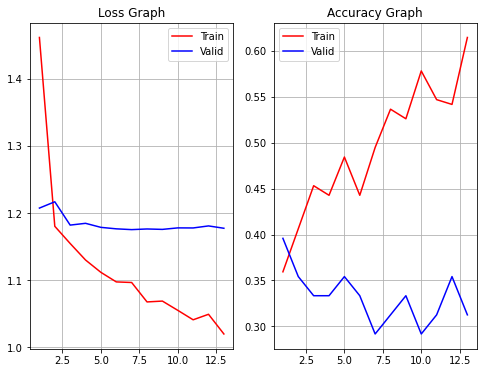


**************************************************



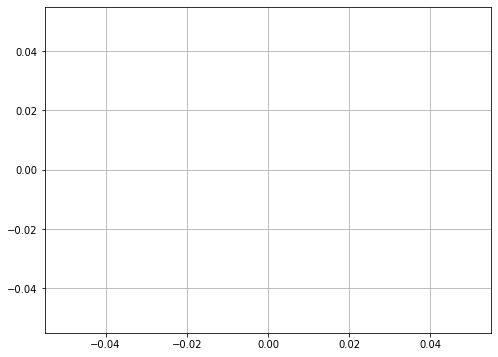


**************************************************



In [9]:
for tr_idx, va_idx in StratifiedKFold(n_splits=cfg.n_splits, random_state=cfg.seed, shuffle=True).split(images, labels):
    break

tr_images, va_images, tr_labels, va_labels, tr_bboxes, va_bboxes = images[tr_idx], images[va_idx], \
                                                                   labels[tr_idx], labels[va_idx], \
                                                                   bboxes[tr_idx], bboxes[va_idx]

tr_data_setup = DS(tr_images, tr_labels.reshape(-1, 1), tr_bboxes, cfg.transform)
va_data_setup = DS(va_images, va_labels.reshape(-1, 1), va_bboxes, cfg.transform)

dataloaders = {
    "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
    "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
}

cfg = CFG(seed=SEED, size=224, epochs=100, batch_size=64, early_stopping=5, lr=1e-4, wd=1e-5, steps_per_epoch=len(dataloaders["train"]))

torch.manual_seed(cfg.seed)
model = Model().to(cfg.device)

# for names, params in model.named_parameters():
#     if params.requires_grad:
#         print(names)

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)

# scheduler_oclr = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
#                                                max_lr=cfg.max_lr, 
#                                                epochs=cfg.epochs, 
#                                                steps_per_epoch=cfg.steps_per_epoch,
#                                                pct_start=cfg.pct_start, 
#                                                div_factor=cfg.div_factor, 
#                                                final_div_factor=cfg.final_div_factor)
# scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
#                                                        patience=cfg.patience,
#                                                        eps=cfg.eps,
#                                                        verbose=True)

scheduler_oclr = None
scheduler_rlrop = None

L, A, LRs, BLE, BAE, name = fit(model=model, 
                                optimizer=optimizer, 
                                scheduler_oclr=scheduler_oclr, 
                                scheduler_rlrop=scheduler_rlrop, 
                                epochs=cfg.epochs, 
                                early_stopping_patience=cfg.early_stopping, 
                                dataloaders=dataloaders, 
                                device=cfg.device,
                                save_path=cfg.save_path,
                                verbose=True)

breaker()
show_graphs(L, A)
breaker()
x_Axis = [i+1 for i in range(len(LRs))]
plt.figure(figsize=(8, 6))
plt.plot(x_Axis, LRs, "rx")
plt.grid()
plt.show()
breaker()

### **Test**

In [10]:
test_image_files = [filename for filename in os.listdir(cfg.test_path) if filename[-3:] == "jpg" or filename[-3:] == "png"]
test_xml_files   = [filename for filename in os.listdir(cfg.test_path) if filename[-3:] == "xml"]